## 2a Pràctica IA: Machine Learning


En aquesta pràctica el nostre objectiu és aplicar diferents classificadors a un problema real. En el nostre cas, prediurem les probabilitats de sobreviure al Titanic segons unes característiques elegides.

### 1 Observació de dades


In [50]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### 1.1 Observació de dades

In [2]:
data=pd.read_csv("./dades.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

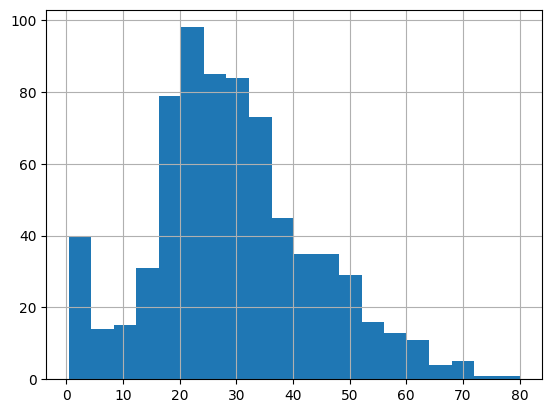

In [4]:
data.Age.hist(bins=20)

<AxesSubplot:>

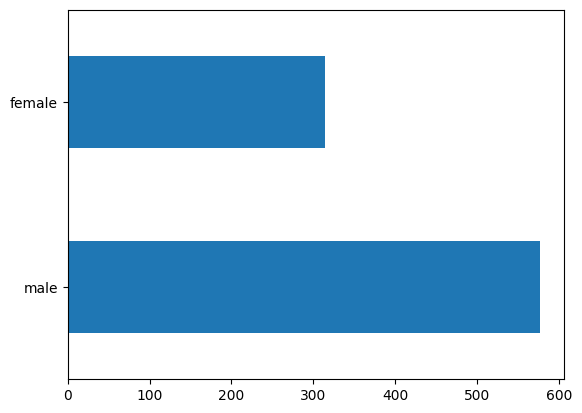

In [5]:
data.Sex.value_counts().plot(kind='barh')

<AxesSubplot:>

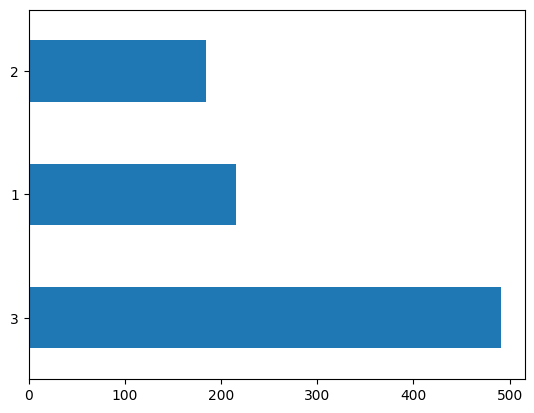

In [6]:
data.Pclass.value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Sex'>

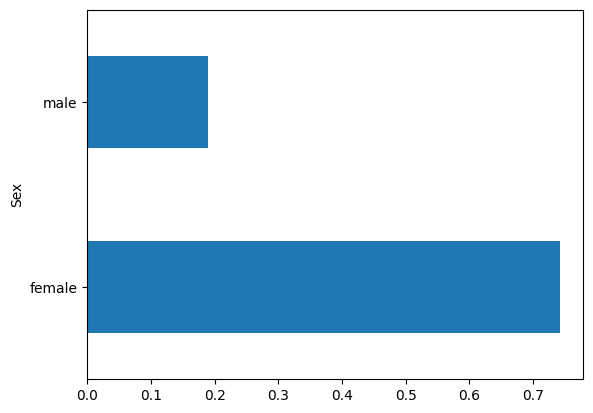

In [7]:
mitjaSupervivenciaSexe=pd.concat([data['Sex'], data['Survived']], axis=1).groupby('Sex').Survived.mean()
mitjaSupervivenciaSexe.plot(kind='barh')

Després d'haver explorat tot el nostre dataset del Titanic, obtenim aquestes conclusions:
#### 1.La majoria de la gent té entre 20-30 anys.
#### 2.La majoria són homes
#### 3.La majoria estava a tercera classe,suposam que era la més econòmica.
#### 4.El % de supervivència en dones és molt major que els homes, suposant que tenien lloc abans en els bots auxiliars.


### 1.2 Manipulació dades


Després d'haver observat el dataset podem eliminar diverses característiques que no ens serviran. Per exemple: PassengerId només ens serveix per a enumerar les files. A continuació eliminarem les columnes que no ens aporten gran informació respecte al percentage de supervivència.

In [8]:
data.drop(["PassengerId","Ticket","Name"],inplace=True,axis=1)
print("La quantitat de NAN's en Cabin es {}/{}".format(data['Cabin'].isna().sum(),len(data)))

La quantitat de NAN's en Cabin es 687/891


Després d'haver eliminat aquestes columnes podem observarque la columna Cabin té gran quantitat de NAN's.També podem observar que tant PassengerID com ticket i Name ens serveixen de identificadors, informació que no sirà molt relevant. Ara eliminam Cabin.

In [9]:
data=data.drop(["Cabin"],axis=1)

In [10]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Ara, després d'haver eliminat les característiques que trobam innecessàries o millor dit, no tant relevants, observarem si ens falta informació a les columnes que agafarem finalment.

In [11]:
total = data.isnull().sum().sort_values(ascending = False)
percentatge = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percentatge], axis=1, keys=['Total', 'percentatge'])
ms= ms[ms["percentatge"] > 0]
ms

,Total,percentatge
Age,177,19.865320
Embarked,2,0.224467


Com podem observar, ens falten 177 valors per a l'edat i 2 per a Embarked. Ens centrarem principalment en l'edat ja que és una característica molt més important i que té més relació amb la supervivència. La opció més viable és substituir tots aquests valors per la mitjana. A més, eliminarem les dues files amb el valor NaN de Embarked.


In [12]:
data['Age'].fillna(value=data['Age'].median(),inplace=True)

In [13]:
data.dropna(subset=['Embarked'],inplace=True)

### 1.2.3 Dades Categòriques

En aquesta fase de la neteja de dades obtindrem les dades categòriques i les transformarem a numèriques per a poder entrenar amb elles el nostre model. 

In [14]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Tenim dues columnes categòriques, el sexe i Embarked. Utilitzarem una substitució per 1 en el cas de home i 2 en el cas de dona ja que tan sols hi ha dos possibles valors. En el cas de Embarked, utilitzarem el one hot encoding(hi ha 3 possibles valors).

In [15]:
data['Sex']=data['Sex'].map({'male':1,'female':0}) #Canviam els valors de sexe
embark=data.pop('Embarked')
ohe_embark=pd.get_dummies(embark,prefix='embk')
data=pd.concat([data.reset_index(drop=True),ohe_embark.reset_index(drop=True)],axis=1,sort=False)


In [33]:
pclass=data.pop('Pclass')
ohe_class=pd.get_dummies(pclass,prefix='class')
data=pd.concat([data.reset_index(drop=True),ohe_class.reset_index(drop=True)],axis=1,sort=False)


In [34]:
data

,Survived,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,class_1,class_2,class_3
0,0,1,-0.563674,1,0,-0.500240,0,0,1,0,0,1
1,1,0,0.669217,1,0,0.788947,1,0,0,1,0,0
2,1,0,-0.255451,0,0,-0.486650,0,0,1,0,0,1
3,1,0,0.438050,1,0,0.422861,0,0,1,1,0,0
4,0,1,0.438050,0,0,-0.484133,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,1,-0.178396,0,0,-0.384475,0,0,1,0,1,0
885,1,0,-0.794841,0,0,-0.042213,0,0,1,1,0,0
886,0,0,-0.101340,1,2,-0.174084,0,0,1,0,0,1
887,1,1,-0.255451,0,0,-0.042213,1,0,0,1,0,0


Com a darrera passa per a tenir les dades netes, hauríem de normalitzar les columnes amb valors numèrics alts com Age o Fare. Utilitzarem l'StandardScaler de la llibreria sklearn.

In [41]:
scaler = StandardScaler()
data.Age=scaler.fit_transform(data.Age.values.reshape(-1,1))
data.Fare=scaler.fit_transform(data.Fare.values.reshape(-1,1))
data.SibSp=scaler.fit_transform(data.SibSp.values.reshape(-1,1))
data.Parch=scaler.fit_transform(data.Parch.values.reshape(-1,1))
data

,Survived,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,class_1,class_2,class_3
0,0,1,-0.563674,0.431350,-0.474326,-0.500240,0,0,1,0,0,1
1,1,0,0.669217,0.431350,-0.474326,0.788947,1,0,0,1,0,0
2,1,0,-0.255451,-0.475199,-0.474326,-0.486650,0,0,1,0,0,1
3,1,0,0.438050,0.431350,-0.474326,0.422861,0,0,1,1,0,0
4,0,1,0.438050,-0.475199,-0.474326,-0.484133,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,1,-0.178396,-0.475199,-0.474326,-0.384475,0,0,1,0,1,0
885,1,0,-0.794841,-0.475199,-0.474326,-0.042213,0,0,1,1,0,0
886,0,0,-0.101340,0.431350,2.006119,-0.174084,0,0,1,0,0,1
887,1,1,-0.255451,-0.475199,-0.474326,-0.042213,1,0,0,1,0,0


In [40]:
data['Parch'].max()

6

Després d'haver fet la neteja de dades i obtingut la matriu de correlació ens adonem compte que els principals factors que intervenen en la predicció i que tenen més importància són aquests:

1.Pclass: amb un valor de -0.33, significa que quant menor és la classe, més probabilitats de sobreviure hi ha.
2.Sex: amb un valor de 0.54, significa que quan major sigui aquest valor major prob. de supervivència tindrà la persona. Això es dona ja que hem substituit home per 0 i dona per 1. Si fos al revés, és a dir, que dona fos un nombre inferior que home, aquesta correlació siria negeativa, al tenir més probabilitats de sobreviure quan menor sigui el nombre enter.
3.Fare: té un valor de 0.25, indica la quantitat de diners que es varen pagar. Aquesta columna va lligada amb Pclass ja que quant més es pagava, millor classe es tenia i per tant, major % de sobreviure.

## 1.3 Entrenament

In [51]:
label=data['Survived']

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35, random_state=42)
X_train.pop('Survived')
X_test.pop('Survived')                                                   

280    0
434    1
39     1
417    0
584    1
      ..
819    1
323    0
185    1
41     0
545    1
Name: Survived, Length: 312, dtype: int64

In [47]:
logistic_reg=linear_model.LogisticRegression()
hist=logistic_reg.fit(X_train,y_train)

In [21]:
hist

LogisticRegression()

In [55]:
parameters={'tol':[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], 'C':[np.arange(0.1,2.0,0.1,dtype=float)]}
grid=GridSearchCV(estimator=logistic_reg,param_grid=parameters,cv = 2, n_jobs=-1)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## 1.4 Avaluació


In [52]:
prediccio=logistic_reg.predict(X_test)
print('The accuracy of the Logistic Regression is',round(accuracy_score(prediccio,y_test)*100,2))

The accuracy of the Logistic Regression is 81.73


## 1.5 Funció avaluació segons test size


In [23]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    X_train.pop('Survived')
    X_test.pop('Survived')
    logistic_reg=linear_model.LogisticRegression()
    hist=logistic_reg.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

<function matplotlib.pyplot.show(close=None, block=None)>

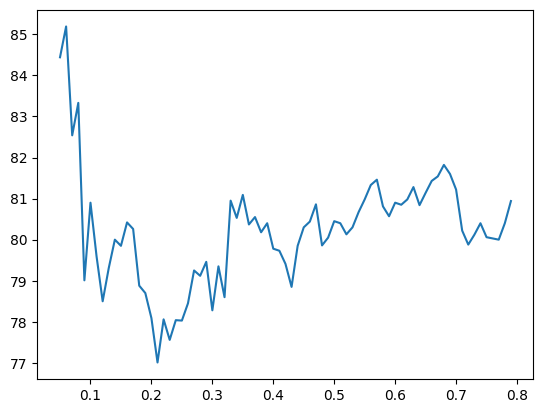

In [24]:
y
plt.plot(x,y)
plt.show

In [25]:
percep=linear_model.Perceptron()
percep.fit(X_train,y_train)
importance=percep.coef_
print(importance)
# plot feature importance

[[ -1.         -11.          -3.55584008  -6.          -3.
    1.12083515   4.           2.           3.        ]]


In [26]:
predict=percep.predict(X_test)


In [27]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    X_train.pop('Survived')
    X_test.pop('Survived')
    percep=linear_model.Perceptron(tol=1e-3,random_state=0)
    percep.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

<function matplotlib.pyplot.show(close=None, block=None)>

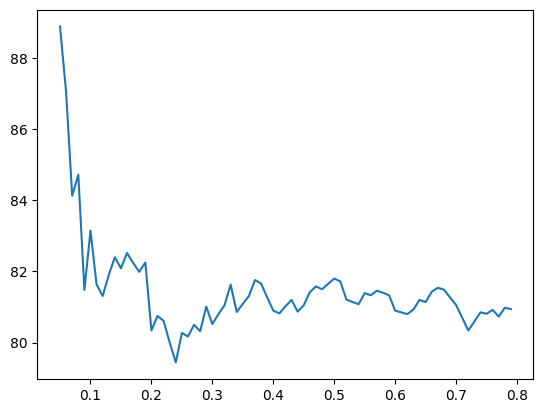

In [28]:
y
plt.plot(x,y)
plt.show

In [29]:
print("Accuracy: "+str(accuracy_score(predict,y_test)))

Accuracy: 0.7610241820768137


In [30]:
from sklearn import tree

In [31]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(X_train, y_train)
predict=decision_tree.predict(X_test)
print("Accuracy: "+str(accuracy_score(predict,y_test)))

Accuracy: 0.7980085348506402
